In [22]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [23]:
def get_data(df, mode='original', emd=False, dimension='one', window_size=0):
    delta_seconds = df.event_timestamp.diff() / np.timedelta64(1, 's')
    delta_seconds[np.where(delta_seconds == 0)[0]] = 1e-3
    delta_seconds = delta_seconds[1:]

    AP = df['Total_AP_energy_max']

    a = []
    for j, i in enumerate(df['Total_AP_energy_max']):
        try:
            i = float(i)
        except ValueError:
            a.append(j)
    for i in a:
        AP[i] = AP[i - 1]

    AP = np.diff(np.array(AP, dtype = float)) * 1000
    X = AP / delta_seconds
    df['total_AP'] = X
    if emd:
        emd = ams()
        emd.emd(X)
        imfs, res = emd.get_imfs_and_residue()
        df['total_AP'] = imfs[2] + X.mean()
    if mode == 'original':   
        if dimension == 'one':
            return np.array(X)
        else:
            df['hour'] = df['event_timestamp'].dt.hour
            df['day'] = df['event_timestamp'].dt.day
            df['weekday'] = df['event_timestamp'].dt.dayofweek
            df['month'] = df['event_timestamp'].dt.month
            X = np.array(df[['total_AP', 'hour', 'day', 'weekday', 'month']])
            return X
    elif mode == 'only_days':
        df = df[(df.event_timestamp.apply(datetime.time) < datetime.strptime('19:00:00', '%H:%M:%S').time()) & \
             (df.event_timestamp.apply(datetime.time) > datetime.strptime('6:40:00', '%H:%M:%S').time())].reset_index(drop=True)
        if dimension == 'one':
            return np.array(df['total_AP'])
        else:
            df['hour'] = df['event_timestamp'].dt.hour
            df['day'] = df['event_timestamp'].dt.day
            df['weekday'] = df['event_timestamp'].dt.dayofweek
            df['month'] = df['event_timestamp'].dt.month
            X = np.array(df[['total_AP', 'hour', 'day', 'weekday', 'month']])
            return X
    elif mode == 'windows':
        ind = np.where(df.event_timestamp.apply(datetime.time) == datetime.strptime('00:00:00', '%H:%M:%S').time())
        ans = []
        prev = 0
        if dimension == 'one':
            for i in ind:
                ans.append(X[prev:i])
                prev = i
            return np.array(ans)
        else:
            df['hour'] = df['event_timestamp'].dt.hour
            df['day'] = df['event_timestamp'].dt.day
            df['weekday'] = df['event_timestamp'].dt.dayofweek
            df['month'] = df['event_timestamp'].dt.month
            for i in ind:
                ans.append(np.array(df[['total_AP', 'hour', 'day', 'weekday', 'month']][prev:i]))
                prev = i
            return np.array(ans)
                
    else:
        print('INCORRECT MODE')
        return None
    

In [ ]:
'''
!!!!!!!!!!!!!!!!!!!!!!!!! мб EMD нужно делать окнами !!!!!!!!!!!!!!!!!!!!!!!!!!!!
curr = S[start[i]: end[i]]
  emd = EMD()
  emd.emd(curr)
  imfs, res = emd.get_imfs_and_residue()
  S[start[i]: end[i]] = imfs[2] + curr.mean()
'''

'''
original
original emd
original multi
original multi emd

only_days
only_days emd
only_days multi
only_days multi emd

windows
windows emd
windows multi
windows multi emd
'''

In [12]:
elec = pd.read_csv(r'/Users/veronikalomonosova/Downloads/iqds/ds_electricity.csv')

/Users/veronikalomonosova/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9,10,11,12,13,16,24,25,26,27,28,31,39,40,41,42,43,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
anom_0 = elec[elec.io_id == '5e03a7a2832a17ee33585ea4'].reset_index(drop=True)
anom_0.event_timestamp = pd.to_datetime(anom_0.event_timestamp, unit='s')

In [16]:
df = anom_0.loc[532778 - 730 * 10:532778 + 720 * 10].reset_index(drop=True) 

In [26]:
df = get_data(df)

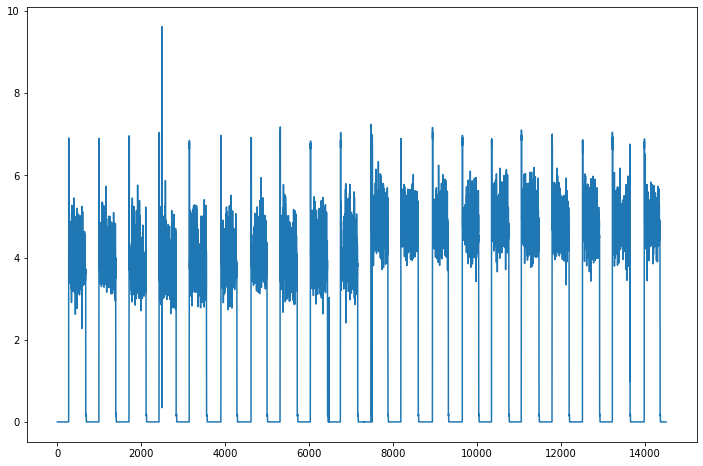

In [27]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(df)), df)